In [1]:
#Bibliotecas
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from IPython.display import HTML
pd.set_option("display.max_columns", None)
from scipy import stats #testes estatísticos e padronização Zscores pela função 'zscore'
import plotly.graph_objs as go #gráfico 3D
import matplotlib.pyplot as plt #biblioteca de visualização de dados
import seaborn as sns #biblioteca de visualização de informações estatísticas
import plotly.express as px #biblioteca para gráficos interativos
import plotly.io as pio #biblioteca para gráficos interativos
pio.renderers.default = 'browser' #biblioteca para gráficos interativos
from scipy.spatial import distance_matrix #construção da matriz de dissimilaridades
import scipy.cluster.hierarchy as sch #elaboração de clusterização hierárquica
from sklearn.cluster import AgglomerativeClustering #definição dos clusters
from sklearn.cluster import KMeans #elaboração de clusterização não hierárquica k-means
import statsmodels.api as sm #biblioteca de modelagem estatística
from statsmodels.formula.api import ols #para elaboração de ANOVA
from sklearn.preprocessing import StandardScaler, MinMaxScaler #padronização de variáveis para o
#método DBSCAN pelo 'scikit-learn'
from sklearn.cluster import DBSCAN #método DBSCAN pelo 'scikit-learn'
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  # Ativa o modo offline

In [2]:
# Carregar a planilha CNAE_Subclasses_2_3_Estrutura_Detalhada.xlsx
df_cnae_2_3 = pd.read_excel('CNAE_Subclasses_2_3_Estrutura_Detalhada.xlsx')
# Tratar planilha
df_cnae_2_3 = df_cnae_2_3.rename(columns={'Seção':'SECAO',
                        'Divisão':'DIVISAO',
                        'Grupo':'GRUPO',
                        'Classe':'CLASSE'})
df_secao = df_cnae_2_3[['SECAO','Denominação']]
df_secao = df_secao.dropna().reset_index()
df_secao = df_secao[['SECAO','Denominação']]
df_secao = df_secao.rename(columns={'Denominação':'DESCRICAO_SECAO'})    
df_divisao = df_cnae_2_3[['DIVISAO','Denominação']]
df_divisao = df_divisao.dropna().reset_index()
df_divisao = df_divisao[['DIVISAO','Denominação']]
df_divisao = df_divisao.rename(columns={'Denominação':'DESCRICAO_DIVISAO'})
df_divisao['CHAVE'] = df_divisao['DIVISAO'].astype(str).str.slice(0, -2)
df_grupo = df_cnae_2_3[['GRUPO','Denominação']]
df_grupo = df_grupo.dropna().reset_index()
df_grupo = df_grupo[['GRUPO','Denominação']]
df_grupo = df_grupo.rename(columns={'Denominação':'DESCRICAO_GRUPO'})
df_grupo['CHAVE'] = df_grupo['GRUPO'].astype(str).str.slice(0, -2)
df_classe = df_cnae_2_3[['CLASSE','Denominação']]
df_classe = df_classe.dropna().reset_index()
df_classe = df_classe[['CLASSE','Denominação']]
df_classe['CHAVE'] = df_classe['CLASSE'].astype(str).str.slice(0, 4)
df_classe = df_classe.rename(columns={'Denominação':'DESCRICAO_CLASSE'})
df_classe['CHAVE'] = df_classe['CHAVE'].astype(str).str.lstrip("0")
df_cnae_2_3['SECAO'] = df_cnae_2_3['SECAO'].ffill()
df_cnae_2_3 = df_cnae_2_3[['SECAO','DIVISAO']]
df_cnae_2_3 = df_cnae_2_3.dropna()
df_cnae_2_3 = df_cnae_2_3.merge(df_secao,on='SECAO',how='left')
df_cnae_2_3 = df_cnae_2_3.merge(df_divisao,on='DIVISAO',how='left')
df_cnae_2_3 = df_cnae_2_3.merge(df_grupo,on='CHAVE',how='left')
df_cnae_2_3['GRUPO'] = df_cnae_2_3['GRUPO'].astype(str)
df_classe['CHAVE'] = df_classe['CHAVE'].astype(str)
df_cnae_2_3 = df_cnae_2_3.merge(df_classe,left_on='GRUPO',right_on='CHAVE',how='left')
df_cnae_2_3 = df_cnae_2_3[['SECAO', 'DESCRICAO_SECAO', 'DIVISAO', 'DESCRICAO_DIVISAO',
       'GRUPO', 'DESCRICAO_GRUPO', 'CLASSE', 'DESCRICAO_CLASSE']]
df_cnae_2_3['CLASSE'] = df_cnae_2_3['CLASSE'].str.replace('.', '').str.replace('-', '')
df_cnae_2_3['CLASSE'] = df_cnae_2_3['CLASSE'].astype(int)
df_cnae_2_3 = df_cnae_2_3.drop_duplicates()
df_cnae = df_cnae_2_3[['CLASSE','DESCRICAO_CLASSE']].drop_duplicates()

In [3]:
#Carregar banco de dados do CAGED
df_caged_movimentacoes = pd.read_csv('df_caged_movimentacoes.csv', sep=';')
#Tratamento banco de dados do CAGED
#Filtrar apenas os meses de ago/2023 a jul/2024
df_caged_movimentacoes = df_caged_movimentacoes[(df_caged_movimentacoes['COMPETENCIAMOV'].isin([202407, 202406, 202405, 202404, 202403, 202402, 202401, 202312, 202311, 202310, 202309, 202308]))]
#Criar variável Classe
df_caged_movimentacoes['CLASSE'] = df_caged_movimentacoes['SUBCLASSE'].astype(str).str.slice(0, -2)
df_caged_movimentacoes['CLASSE'] = df_caged_movimentacoes['CLASSE'].astype(int)
#Converter a variável de 'object' para 'int'
df_caged_movimentacoes['VALORSALARIOFIXO'] = pd.to_numeric(df_caged_movimentacoes['VALORSALARIOFIXO'], errors='coerce')
# Filtrar contratações (saldo_movimentacao = 1) e demissões (saldo_movimentacao = -1)
df_contratacoes = df_caged_movimentacoes[df_caged_movimentacoes['SALDOMOVIMENTACAO'] == 1]
df_demissoes = df_caged_movimentacoes[df_caged_movimentacoes['SALDOMOVIMENTACAO'] == -1]
# Agrupar por CLASSE para calcular o total de contratações e demissões
total_movimentacoes = df_caged_movimentacoes.groupby('CLASSE')['SALDOMOVIMENTACAO'].sum().reset_index()
# Calcular a quantidade de contratações
qtd_contratacoes = df_contratacoes.groupby('CLASSE')['_id'].count().reset_index()
qtd_contratacoes.rename(columns={'_id': 'qtd_contratacoes'}, inplace=True)
# Calcular a quantidade de demissoes
qtd_demissoes = df_demissoes.groupby('CLASSE')['_id'].count().reset_index()
qtd_demissoes.rename(columns={'_id': 'qtd_demissoes'}, inplace=True)
# Calcular a média dos salários de contratações
salario_medio_contratacoes = df_contratacoes.groupby('CLASSE')['VALORSALARIOFIXO'].median().reset_index()
salario_medio_contratacoes.rename(columns={'VALORSALARIOFIXO': 'SALARIO_MEDIO_CONTRATACAO'}, inplace=True)
# Calcular a média dos salários de demissões
salario_medio_demissoes = df_demissoes.groupby('CLASSE')['VALORSALARIOFIXO'].median().reset_index()
salario_medio_demissoes.rename(columns={'VALORSALARIOFIXO': 'SALARIO_MEDIO_DEMISSAO'}, inplace=True)

/tmp/ipykernel_1628323/1143154915.py:2: DtypeWarning:

Columns (12,21,28) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
#Carregar banco de dados da Receita Federal
df_receita_federal = pd.read_json("estabelecimentos_pr.json")
#Tratamento banco de dados da Receita Federal
#Criar variável Classe
df_receita_federal['CLASSE'] = df_receita_federal['CNAE_FISCAL_PRINCIPAL'].astype(str).str.slice(0, -2)
df_receita_federal['CLASSE'] = df_receita_federal['CLASSE'].astype(int)
#Trasnformar variável em data
df_receita_federal['DATA_DE_INICIO_ATIVIDADE'] = pd.to_datetime(df_receita_federal['DATA_DE_INICIO_ATIVIDADE'], format='%Y%m%d')

# Função para calcular a idade
def calcular_idade(data_nascimento):
    hoje = datetime.now()
    return relativedelta(hoje, data_nascimento).years

#Aplicar a função para calcular a idade para cada linha da coluna 'DATA_DE_INICIO_ATIVIDADE'
df_receita_federal['NR_IDADE_PJ'] = df_receita_federal['DATA_DE_INICIO_ATIVIDADE'].apply(calcular_idade)
#Trasnformar variável em data
df_receita_federal['DATA_SITUACAO_CADASTRAL'] = df_receita_federal['DATA_SITUACAO_CADASTRAL'].replace('0', pd.NaT)
df_receita_federal['DATA_SITUACAO_CADASTRAL'] = pd.to_datetime(df_receita_federal['DATA_SITUACAO_CADASTRAL'], format='%Y%m%d', errors='coerce')
#Alterar obeservações da variável SITUACAO_CADASTRAL de código para descrição
df_receita_federal['SITUACAO_CADASTRAL'] = df_receita_federal['SITUACAO_CADASTRAL'].astype(str)
df_receita_federal.loc[df_receita_federal['SITUACAO_CADASTRAL'].isin(['1','3','4','8']), 'SITUACAO_CADASTRAL'] = 'Inativa'
df_receita_federal.loc[df_receita_federal['SITUACAO_CADASTRAL'] == '2', 'SITUACAO_CADASTRAL'] = 'Ativa'
#Criar dois novos dataframes, um apenas com filiais e outro apenas com matrizes
df_filial = df_receita_federal[(df_receita_federal['IDENTIFICADOR_MATRIZ_FILIAL'] == 2)]
df_matriz = df_receita_federal[(df_receita_federal['IDENTIFICADOR_MATRIZ_FILIAL'] == 1)]
#Criar métrica idade mediana das empresas agrupada por classe
idade_mediana_pj = pd.pivot_table(df_matriz,index='CLASSE', values='NR_IDADE_PJ',aggfunc='median').reset_index()
#Criar variável com a quantidade de filiais por matriz
qtd_filiais = df_filial.groupby('CNPJ_BASICO').size().reset_index()
df_matriz = df_matriz.merge(qtd_filiais, on='CNPJ_BASICO', how = 'left')
df_matriz = df_matriz.rename(columns = {0:'NR_FILIAIS'})
#Criar métrica numero de filiais mediana das empresas agrupada por classe
filiais_mediana = pd.pivot_table(df_matriz,index='CLASSE', values='NR_FILIAIS',aggfunc='median').reset_index()
#Encontrar a data mais recente no campo SITUACAO_CADASTRAL
data_mais_recente = df_matriz['DATA_SITUACAO_CADASTRAL'].max()
#Calcular a data de 12 meses atrás a partir da data mais recente
data_limite = data_mais_recente - timedelta(days=365)
# Filtrar empresas com base no SITUACAO_CADASTRAL mais recente, considerando os últimos 12 meses
df_filtrado = df_matriz[df_matriz['DATA_SITUACAO_CADASTRAL'] >= data_limite]
# Contagem total de empresas "Inativadas" em 2023 ou 2024 por CLASSE
empresas_inativas_total = df_filtrado[df_filtrado['SITUACAO_CADASTRAL'] == 'Inativa'].groupby('CLASSE').size()
# Contagem total de empresas "Ativada" em 2023 ou 2024 por CLASSE
empresas_ativas_total = df_filtrado[df_filtrado['SITUACAO_CADASTRAL'] == 'Ativa'].groupby('CLASSE').size()
# Cálculo do saldo
saldo_empresas_ativas_inativas = (empresas_ativas_total - empresas_inativas_total)
# Adicionar os percentuais totais
saldo_ativas_inativas = pd.DataFrame({
    'SALDO_EMPRESAS': saldo_empresas_ativas_inativas
}).fillna(0).reset_index()

In [5]:
#Carregar banco de dados do MDIC
df_mdic = pd.read_csv("df_mdic.csv",sep=';')
# Filtrar os últimos 12 meses
df_recente = df_mdic[
    ((df_mdic['CO_ANO'] == 2024) & (df_mdic['CO_MES'] <= 8)) |
    ((df_mdic['CO_ANO'] == 2023) & (df_mdic['CO_MES'] > 8))]
# Filtrar os 12 meses anteriores ao período recente
df_anterior = df_mdic[
    ((df_mdic['CO_ANO'] == 2023) & (df_mdic['CO_MES'] <= 8)) |
    ((df_mdic['CO_ANO'] == 2022) & (df_mdic['CO_MES'] > 8))]
# Calcular a soma de QT_ESTAT por CO_NCM para os dois períodos
qt_estat_recente = df_recente.groupby('CO_NCM')['QT_ESTAT'].sum()
qt_estat_anterior = df_anterior.groupby('CO_NCM')['QT_ESTAT'].sum()
# Subtrair o valor de QT_ESTAT do período anterior do valor do período recente
variação_qt_estat = qt_estat_recente/qt_estat_anterior-1
# Criar um DataFrame com os resultados
df_variação_qt_estat = pd.DataFrame({
    'QT_ESTAT_Recente': qt_estat_recente,
    'QT_ESTAT_Anterior': qt_estat_anterior,
    'VARIACAO_QT_ESTAT': variação_qt_estat
}).fillna(0).reset_index()
#Planilha auxiliar NCM2012XCNAE20 - https://concla.ibge.gov.br/classificacoes/correspondencias/atividades-economicas.html
df_cnae_ncm = pd.read_excel('cnae_ncm.xlsx')
df_cnae_ncm = df_cnae_ncm.dropna()
df_cnae_ncm['NCM 2012 (AGOSTO)'] = df_cnae_ncm['NCM 2012 (AGOSTO)'].astype(int)
# Dividir a coluna 'CNAE 2.0' em listas, quando houver mais de um valor separado por ';'
df_cnae_ncm['CNAE 2.0'] = df_cnae_ncm['CNAE 2.0'].str.split(';')
# Usar explode para criar uma linha para cada valor em 'CNAE 2.0'
df_cnae_ncm = df_cnae_ncm.explode('CNAE 2.0')
# Remover espaços em branco indesejados
df_cnae_ncm['CNAE 2.0'] = df_cnae_ncm['CNAE 2.0'].str.strip()
# Remover o ponto da coluna 'CNAE 2.0' e converter para inteiro
df_cnae_ncm = df_cnae_ncm[(df_cnae_ncm['CNAE 2.0'] != 'XXXX') & (df_cnae_ncm['CNAE 2.0'] != 'SEM TEC')]
df_cnae_ncm['CNAE 2.0'] = df_cnae_ncm['CNAE 2.0'].str.replace('.', '', regex=False)
df_cnae_ncm['CNAE 2.0'] = df_cnae_ncm['CNAE 2.0'].str.replace('-', '', regex=False)
df_cnae_ncm['CNAE 2.0'] = df_cnae_ncm['CNAE 2.0'].str.replace('(fora do âmbito agro/indústria', '', regex=False).astype(int)
#Incluir a CNAE no banco de dados do MDIC
df_cnae_ncm = df_variação_qt_estat.merge(df_cnae_ncm,left_on='CO_NCM',right_on='NCM 2012 (AGOSTO)',how='inner')
df_cnae_ncm = df_cnae_ncm[['CNAE 2.0','CO_NCM','QT_ESTAT_Recente','QT_ESTAT_Anterior']]
df_cnae_ncm = df_cnae_ncm.rename(columns={'CNAE 2.0':'CLASSE'})
#Calcular variação entre os períodos 
df_cnae_ncm_var = pd.pivot_table(df_cnae_ncm,index='CLASSE',values=['QT_ESTAT_Recente','QT_ESTAT_Anterior'],aggfunc='sum').reset_index()
df_cnae_ncm_var['VARIACAO_QT_ESTAT'] = df_cnae_ncm_var['QT_ESTAT_Recente']/df_cnae_ncm_var['QT_ESTAT_Anterior']-1
df_cnae_ncm_var.loc[(df_cnae_ncm_var['VARIACAO_QT_ESTAT'] == np.inf) & (df_cnae_ncm_var['QT_ESTAT_Anterior'] == 0), 'VARIACAO_QT_ESTAT'] = df_cnae_ncm_var['QT_ESTAT_Recente']
df_cnae_ncm_var.loc[(df_cnae_ncm_var['VARIACAO_QT_ESTAT'] == np.inf) & (df_cnae_ncm_var['QT_ESTAT_Recente'] == 0), 'VARIACAO_QT_ESTAT'] = -df_cnae_ncm_var['QT_ESTAT_Anterior']
df_cnae_ncm_var.loc[(df_cnae_ncm_var['VARIACAO_QT_ESTAT'] == 0) & (df_cnae_ncm_var['QT_ESTAT_Anterior'] == 0), 'VARIACAO_QT_ESTAT'] = df_cnae_ncm_var['QT_ESTAT_Recente']
df_cnae_ncm_var.loc[(df_cnae_ncm_var['VARIACAO_QT_ESTAT'] == 0) & (df_cnae_ncm_var['QT_ESTAT_Recente'] == 0), 'VARIACAO_QT_ESTAT'] = -df_cnae_ncm_var['QT_ESTAT_Anterior']
df_cnae_ncm_var = df_cnae_ncm_var.round(2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_cnae_ncm_var['QT_ESTAT_Anterior'] = df_cnae_ncm_var['QT_ESTAT_Anterior'].astype(int)
df_cnae_ncm_var['QT_ESTAT_Recente'] = df_cnae_ncm_var['QT_ESTAT_Recente'].astype(int)
df_cnae_ncm_var = df_cnae_ncm_var[['CLASSE','VARIACAO_QT_ESTAT']]

In [6]:
df_final = df_cnae.merge(total_movimentacoes,on='CLASSE',how='left')
df_final = df_final.merge(salario_medio_contratacoes,on='CLASSE',how='left')
df_final = df_final.merge(salario_medio_demissoes,on='CLASSE',how='left')
df_final = df_final.merge(idade_mediana_pj,on='CLASSE',how='left')
df_final = df_final.merge(filiais_mediana,on='CLASSE',how='left')
df_final = df_final.merge(saldo_ativas_inativas,on='CLASSE',how='left')
df_final = df_final.merge(df_cnae_ncm_var,on='CLASSE',how='left')

In [7]:
df_final = df_final.fillna(0)
df_final.rename(columns={'NR_IDADE_PJ':'MEDIANA_IDADE_PJ',
                         'NR_FILIAIS':'MEDIANA_FILIAIS_PJ',
                         'VARIACAO_QT_ESTAT':'VARIACAO_EXPORTACAO'}, inplace=True)
df_final

,CLASSE,DESCRICAO_CLASSE,SALDOMOVIMENTACAO,SALARIO_MEDIO_CONTRATACAO,SALARIO_MEDIO_DEMISSAO,MEDIANA_IDADE_PJ,MEDIANA_FILIAIS_PJ,SALDO_EMPRESAS,VARIACAO_EXPORTACAO
0,1113,Cultivo de cereais,-201.00,1749.02,1804.30,12.00,1.00,54.00,1.48
1,1121,Cultivo de algodão herbáceo e de outras fibras...,5.00,1749.02,1824.00,16.00,1.00,0.00,0.92
2,1130,Cultivo de cana-de-açúcar,-152.00,1595.30,1577.10,13.00,2.00,9.00,10655.67
3,1148,Cultivo de fumo,2.00,1678.00,1617.00,34.00,1.00,0.00,0.00
4,1156,Cultivo de soja,-182.00,1750.00,1780.00,4.00,1.00,179.00,0.60
...,...,...,...,...,...,...,...,...,...
668,96025,Cabeleireiros e outras atividades de tratament...,37.00,1898.49,1898.49,5.00,1.00,3322.00,0.07
669,96033,Atividades funerárias e serviços relacionados,116.00,1784.94,1816.00,20.00,1.00,-6.00,0.00
670,96092,Atividades de serviços pessoais não especifica...,149.00,1600.00,1600.00,5.00,1.00,294.00,0.00
671,97005,Serviços domésticos,28.00,1534.00,1430.00,3.00,2.00,1386.00,0.00


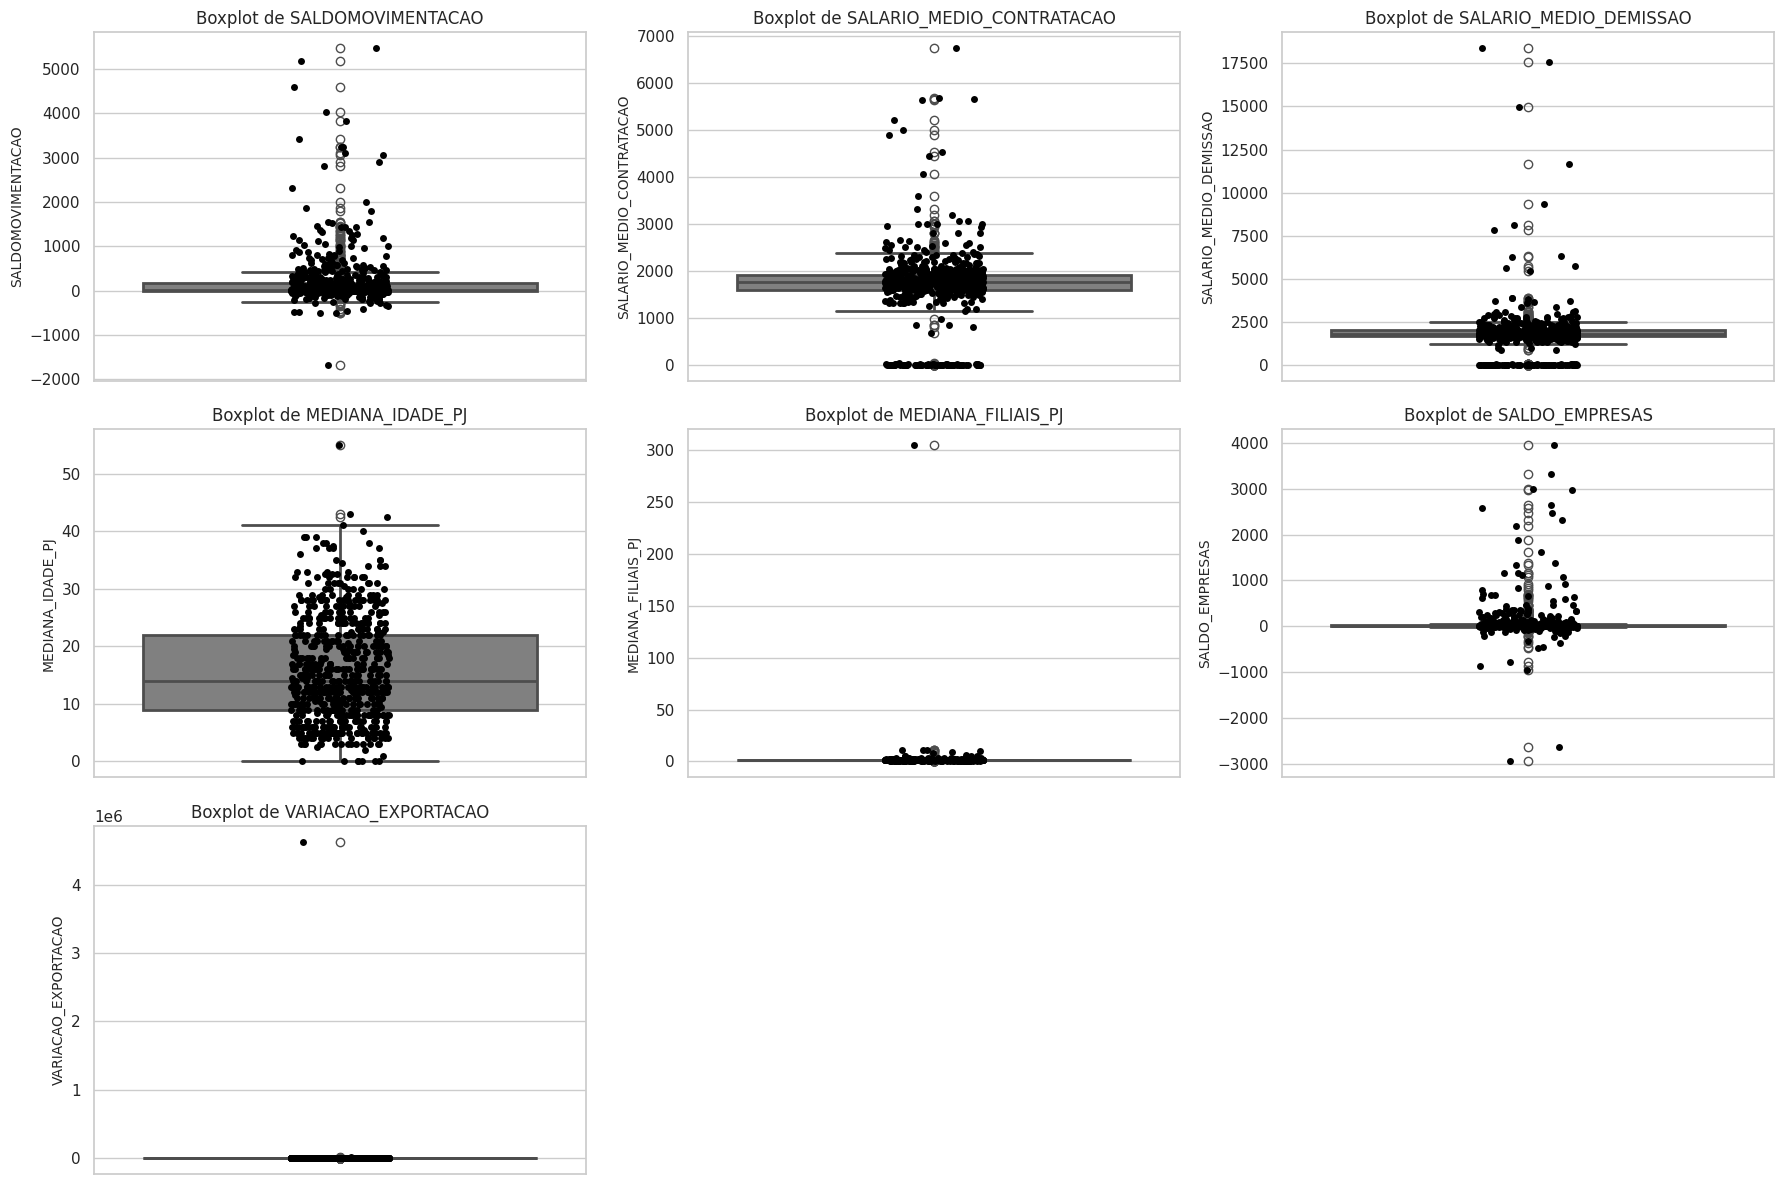

In [8]:
# Definir estilo e paleta
sns.set(style="whitegrid", palette="gray")

# Lista das variáveis a serem plotadas
variaveis = [
    'SALDOMOVIMENTACAO', 'SALARIO_MEDIO_CONTRATACAO', 'SALARIO_MEDIO_DEMISSAO', 
    'MEDIANA_IDADE_PJ', 'MEDIANA_FILIAIS_PJ', 'SALDO_EMPRESAS','VARIACAO_EXPORTACAO'
]

# Definir grid: 3 linhas x 3 colunas (ajuste conforme necessário)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # Ajuste de tamanho
axes = axes.flatten()  # Facilita o loop

# Loop para criar gráficos individualmente
for i, var in enumerate(variaveis):
    sns.boxplot(data=df_final, y=var, ax=axes[i], color='gray', linewidth=2)
    sns.stripplot(data=df_final, y=var, ax=axes[i], color="black", jitter=0.1, size=5)
    axes[i].set_title(f'Boxplot de {var}', fontsize=12)
    axes[i].set_xlabel('')  # Remover rótulo do eixo x
    axes[i].set_ylabel(var, fontsize=10)  # Adicionar rótulo ao eixo y

# Remover eixos não utilizados (caso haja menos variáveis do que subplots)
for j in range(len(variaveis), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()


In [9]:
#Tratamento de outliers para rodar a clusterização
df_cluster = df_final.copy()
df_cluster['SALDOMOVIMENTACAO'] = np.clip(df_cluster['SALDOMOVIMENTACAO'], -250, 500)
df_cluster['SALDO_EMPRESAS'] = np.clip(df_cluster['SALDO_EMPRESAS'], 0, 40)
df_cluster['VARIACAO_EXPORTACAO'] = np.clip(df_cluster['VARIACAO_EXPORTACAO'], -2, 3)
df_cluster['MEDIANA_IDADE_PJ'] = np.clip(df_cluster['MEDIANA_IDADE_PJ'], 0, 40)
df_cluster['MEDIANA_FILIAIS_PJ'] = np.clip(df_cluster['MEDIANA_FILIAIS_PJ'], 0, 2)
df_cluster['SALARIO_MEDIO_CONTRATACAO'] = np.clip(df_cluster['SALARIO_MEDIO_CONTRATACAO'], 1000, 2500)
df_cluster['SALARIO_MEDIO_DEMISSAO'] = np.clip(df_cluster['SALARIO_MEDIO_DEMISSAO'], 1000, 2500)

In [10]:
df_final

,CLASSE,DESCRICAO_CLASSE,SALDOMOVIMENTACAO,SALARIO_MEDIO_CONTRATACAO,SALARIO_MEDIO_DEMISSAO,MEDIANA_IDADE_PJ,MEDIANA_FILIAIS_PJ,SALDO_EMPRESAS,VARIACAO_EXPORTACAO
0,1113,Cultivo de cereais,-201.00,1749.02,1804.30,12.00,1.00,54.00,1.48
1,1121,Cultivo de algodão herbáceo e de outras fibras...,5.00,1749.02,1824.00,16.00,1.00,0.00,0.92
2,1130,Cultivo de cana-de-açúcar,-152.00,1595.30,1577.10,13.00,2.00,9.00,10655.67
3,1148,Cultivo de fumo,2.00,1678.00,1617.00,34.00,1.00,0.00,0.00
4,1156,Cultivo de soja,-182.00,1750.00,1780.00,4.00,1.00,179.00,0.60
...,...,...,...,...,...,...,...,...,...
668,96025,Cabeleireiros e outras atividades de tratament...,37.00,1898.49,1898.49,5.00,1.00,3322.00,0.07
669,96033,Atividades funerárias e serviços relacionados,116.00,1784.94,1816.00,20.00,1.00,-6.00,0.00
670,96092,Atividades de serviços pessoais não especifica...,149.00,1600.00,1600.00,5.00,1.00,294.00,0.00
671,97005,Serviços domésticos,28.00,1534.00,1430.00,3.00,2.00,1386.00,0.00


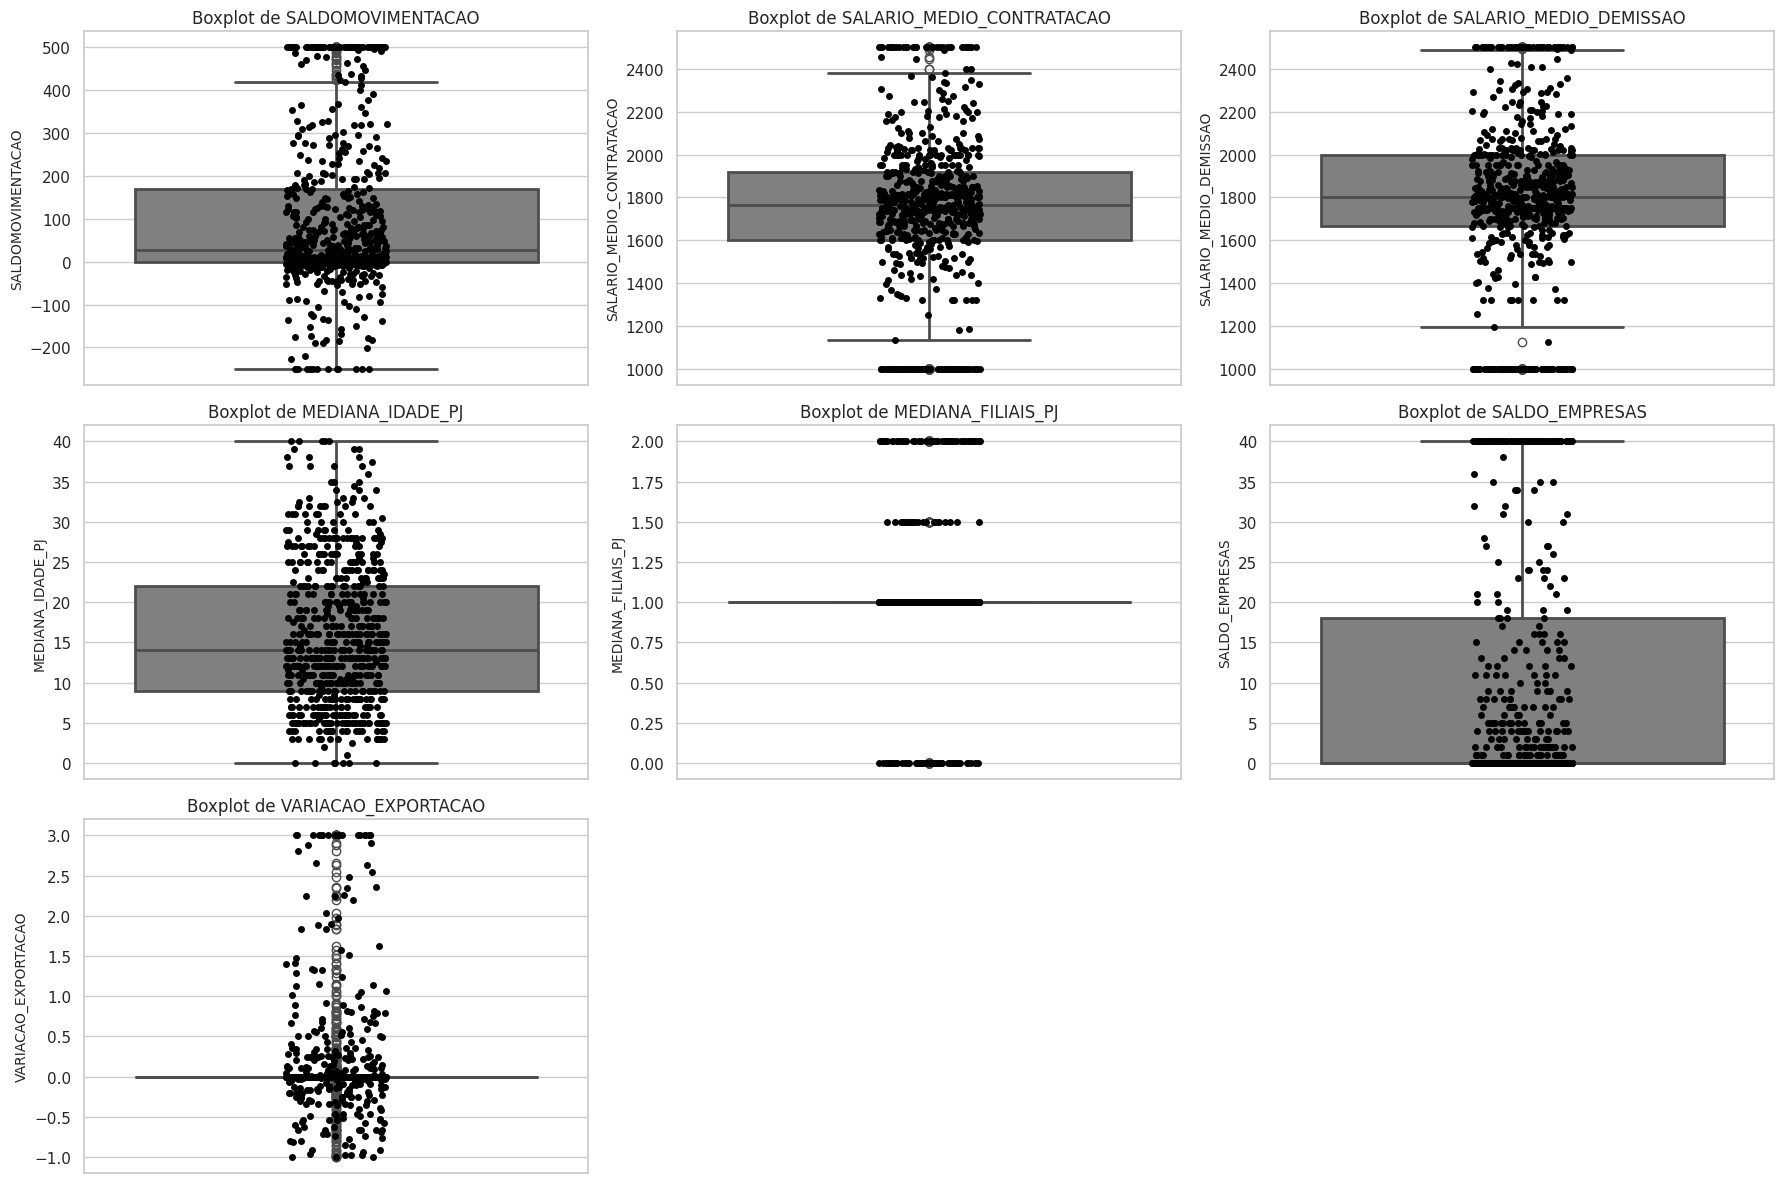

In [11]:
# Definir estilo e paleta
sns.set(style="whitegrid", palette="gray")

# Lista das variáveis a serem plotadas
variaveis = [
    'SALDOMOVIMENTACAO', 'SALARIO_MEDIO_CONTRATACAO', 'SALARIO_MEDIO_DEMISSAO', 
    'MEDIANA_IDADE_PJ', 'MEDIANA_FILIAIS_PJ', 'SALDO_EMPRESAS','VARIACAO_EXPORTACAO'
]

# Definir grid: 3 linhas x 3 colunas (ajuste conforme necessário)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # Ajuste de tamanho
axes = axes.flatten()  # Facilita o loop

# Loop para criar gráficos individualmente
for i, var in enumerate(variaveis):
    sns.boxplot(data=df_cluster, y=var, ax=axes[i], color='gray', linewidth=2)
    sns.stripplot(data=df_cluster, y=var, ax=axes[i], color="black", jitter=0.1, size=5)
    axes[i].set_title(f'Boxplot de {var}', fontsize=12)
    axes[i].set_xlabel('')  # Remover rótulo do eixo x
    axes[i].set_ylabel(var, fontsize=10)  # Adicionar rótulo ao eixo y

# Remover eixos não utilizados (caso haja menos variáveis do que subplots)
for j in range(len(variaveis), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()


In [13]:
scaler = StandardScaler()
df_cluster['SALDOMOVIMENTACAO'] = scaler.fit_transform(df_cluster[['SALDOMOVIMENTACAO']])
df_cluster['SALARIO_MEDIO_CONTRATACAO'] = scaler.fit_transform(df_cluster[['SALARIO_MEDIO_CONTRATACAO']])
df_cluster['SALARIO_MEDIO_DEMISSAO'] = scaler.fit_transform(df_cluster[['SALARIO_MEDIO_DEMISSAO']])
df_cluster['MEDIANA_IDADE_PJ'] = scaler.fit_transform(df_cluster[['MEDIANA_IDADE_PJ']])
df_cluster['SALDO_EMPRESAS'] = scaler.fit_transform(df_cluster[['SALDO_EMPRESAS']])
df_cluster['VARIACAO_EXPORTACAO'] = scaler.fit_transform(df_cluster[['VARIACAO_EXPORTACAO']])
df_cluster['MEDIANA_FILIAIS_PJ'] = scaler.fit_transform(df_cluster[['MEDIANA_FILIAIS_PJ']])

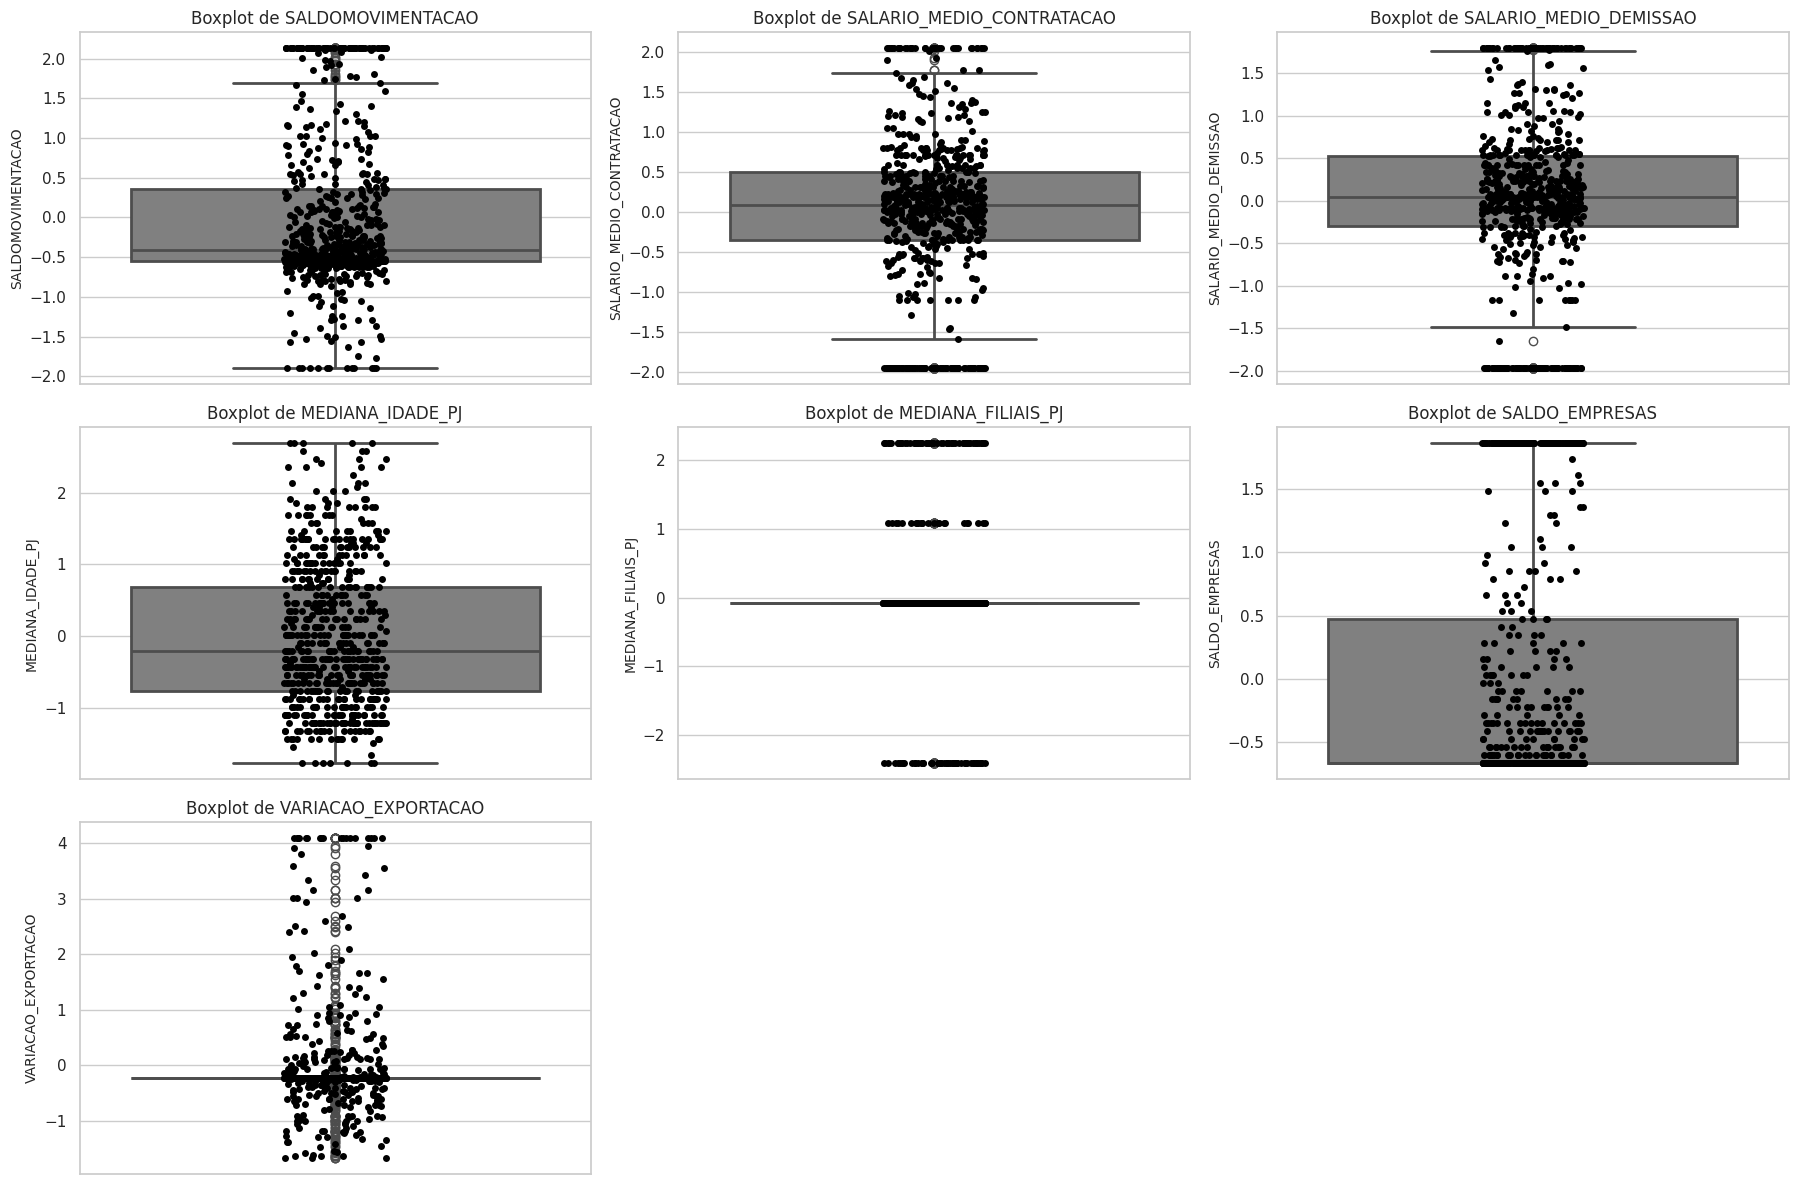

In [15]:
# Definir estilo e paleta
sns.set(style="whitegrid", palette="gray")

# Lista das variáveis a serem plotadas
variaveis = [
    'SALDOMOVIMENTACAO', 'SALARIO_MEDIO_CONTRATACAO', 'SALARIO_MEDIO_DEMISSAO', 
    'MEDIANA_IDADE_PJ', 'MEDIANA_FILIAIS_PJ', 'SALDO_EMPRESAS','VARIACAO_EXPORTACAO'
]

# Definir grid: 3 linhas x 3 colunas (ajuste conforme necessário)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # Ajuste de tamanho
axes = axes.flatten()  # Facilita o loop

# Loop para criar gráficos individualmente
for i, var in enumerate(variaveis):
    sns.boxplot(data=df_cluster, y=var, ax=axes[i], color='gray', linewidth=2)
    sns.stripplot(data=df_cluster, y=var, ax=axes[i], color="black", jitter=0.1, size=5)
    axes[i].set_title(f'Boxplot de {var}', fontsize=12)
    axes[i].set_xlabel('')  # Remover rótulo do eixo x
    axes[i].set_ylabel(var, fontsize=10)  # Adicionar rótulo ao eixo y

# Remover eixos não utilizados (caso haja menos variáveis do que subplots)
for j in range(len(variaveis), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()


In [17]:
#Delimitação das variáveis que serão utilizadas na análise de agrupamentos
df_cluster = df_cluster[['CLASSE', 'DESCRICAO_CLASSE', 'SALDOMOVIMENTACAO', 'SALDO_EMPRESAS','VARIACAO_EXPORTACAO']]

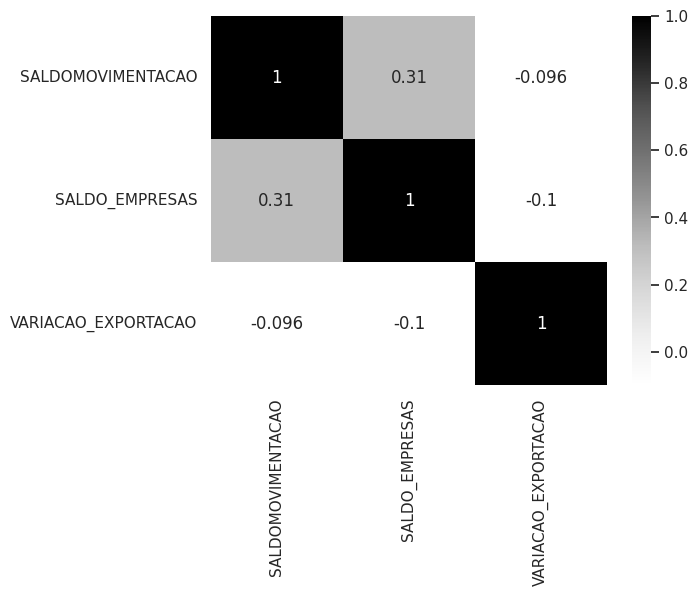

In [18]:
matriz_correlacao = df_cluster.iloc[0:,2:5].corr()
sns.heatmap(matriz_correlacao, annot=True, cmap='Grays')
plt.show()


Frequência de clusters para ['SALDOMOVIMENTACAO', 'SALDO_EMPRESAS']:
0    673
Name: count, dtype: int64

Frequência de clusters para ['SALDOMOVIMENTACAO', 'VARIACAO_EXPORTACAO']:
 0    670
-1      3
Name: count, dtype: int64

Frequência de clusters para ['SALDO_EMPRESAS', 'VARIACAO_EXPORTACAO']:
 0    670
-1      3
Name: count, dtype: int64


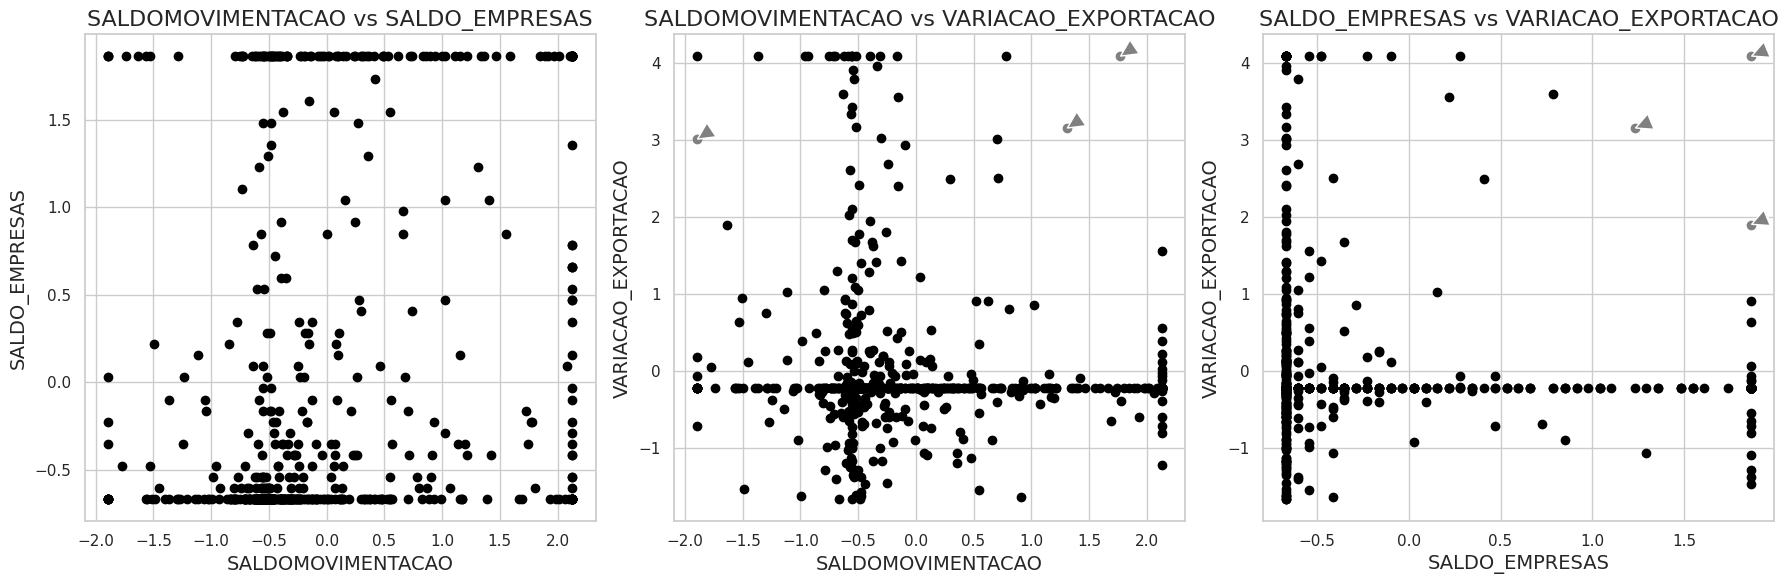

In [19]:
#Detecção de outliers multivariados

# Função para aplicar DBSCAN e retornar rótulos
def aplicar_dbscan(df, cols, eps=1.0, min_samples=10):
    X = df[cols].values  # Sem normalização adicional
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = dbscan.labels_

    print(f"\nFrequência de clusters para {cols}:")
    print(pd.Series(labels).value_counts())

    return X, labels

# Configuração da figura com subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 linha, 3 colunas
combinacoes = [
    ['SALDOMOVIMENTACAO', 'SALDO_EMPRESAS'],
    ['SALDOMOVIMENTACAO', 'VARIACAO_EXPORTACAO'],
    ['SALDO_EMPRESAS', 'VARIACAO_EXPORTACAO']
]
colors = ['black', 'gray']  # Preto e cinza (outliers)

# Loop para gerar os três gráficos
for ax, cols in zip(axes, combinacoes):
    X, labels = aplicar_dbscan(df_cluster, cols)
    unique_labels = set(labels)

    for color, label in zip(colors, unique_labels):
        sample_mask = np.array(labels) == label
        ax.plot(X[:, 0][sample_mask], X[:, 1][sample_mask], 'o', color=color)

        # Adicionando setas para outliers (rótulo -1)
        if label == -1:
            for i in np.where(sample_mask)[0]:
                ax.annotate(
                    '', 
                    xy=(X[i, 0], X[i, 1]),  # Coordenada do ponto
                    xytext=(X[i, 0] + 0.1, X[i, 1] + 0.1),  # Deslocamento da seta
                    arrowprops=dict(facecolor='gray', shrink=0.05, width=0.5)
                )

    ax.set_xlabel(cols[0], fontsize=14)
    ax.set_ylabel(cols[1], fontsize=14)
    ax.set_title(f'{cols[0]} vs {cols[1]}', fontsize=16)

# Ajuste de layout e exibição
plt.tight_layout()
plt.show()


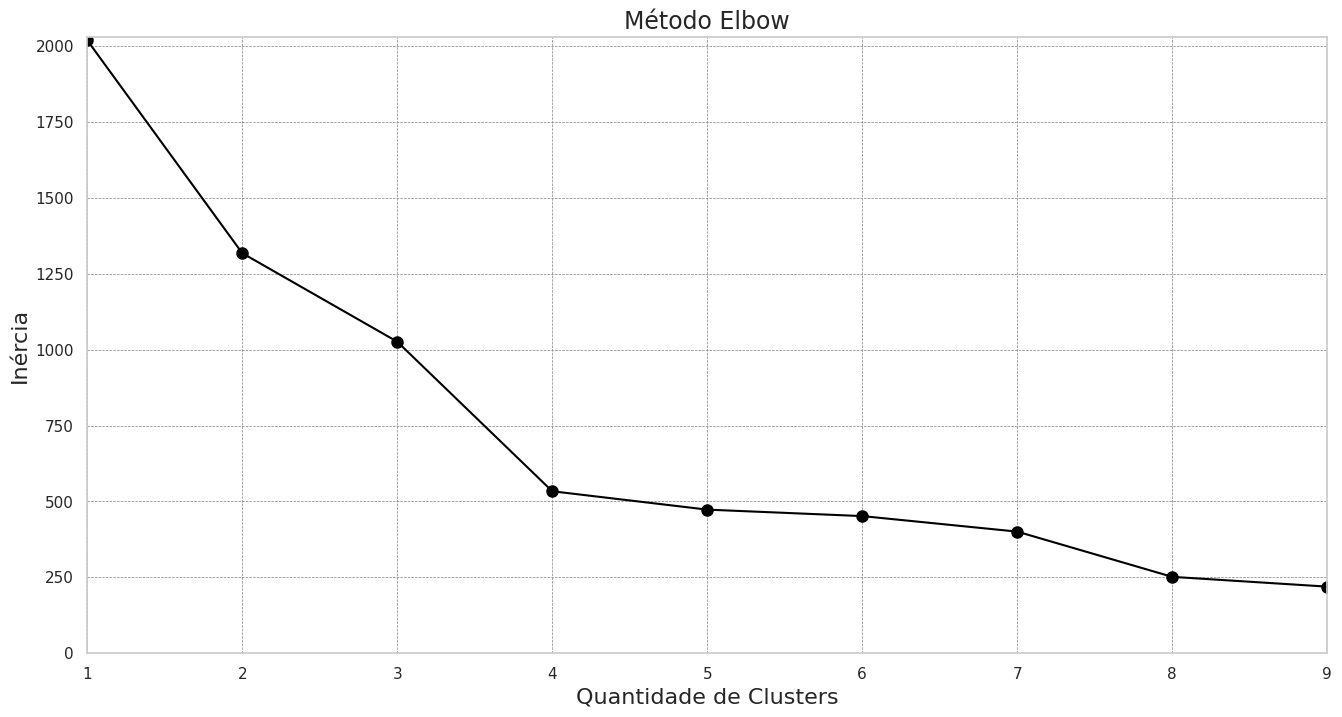

In [20]:
# Método Elbow (ou método do cotovelo) para a identificação da quantidade de
#clusters
# Elaborado com base na 'inércia' (distância de cada obervação para o centróide
#de seu cluster. Quanto mais próximas as observaçções entre si e do centróide,
#menor a inércia

inercias = []
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(df_cluster.iloc[:, 2:5])
    inercias.append(kmeanModel.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K, inercias, color='black', marker='o', linestyle='-', markersize=8)
plt.xlabel('Quantidade de Clusters', fontsize=16)
plt.ylabel('Inércia', fontsize=16)
plt.title('Método Elbow', fontsize=17)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlim(1, 9)
plt.ylim(0, max(inercias) + 10)  # Ajuste o limite do eixo y conforme necessário
plt.show()


In [21]:
# Elaboração da clusterização não hieráquica k-means

kmeans = KMeans(n_clusters = 4,
                random_state=42).fit(df_cluster.iloc[0:,2:5])
cluster_K = kmeans.labels_

# Visualização da base de dados com a alocação das observações nos clusters
#gerados por meio do procedimento k-means
df_cluster['cluster_K'] = cluster_K

In [22]:
# Definição de função para a elaboração de análise de variância de um fator
#(ANOVA)

def teste_f_kmeans(kmeans, dataframe):
    variaveis = dataframe.columns
    centroides = pd.DataFrame(kmeans.cluster_centers_)
    centroides.columns = dataframe.columns
    centroides
    print("Centróides: \n", centroides ,"\n")
    df = dataframe[variaveis]
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    dic = dict(zip(unique, counts))
    qnt_clusters = kmeans.n_clusters
    observacoes = len(kmeans.labels_)
    df['cluster'] = kmeans.labels_
    ANOVA = []
    for variavel in variaveis:
        dic_var={'variavel':variavel}
        # Variabilidade entre os grupos
        variabilidade_entre_grupos = np.sum([dic[index]*np.square(observacao - df[variavel].mean()) for index, observacao in enumerate(centroides[variavel])])/(qnt_clusters - 1)
        dic_var['variabilidade_entre_grupos'] = variabilidade_entre_grupos
        variabilidade_dentro_dos_grupos = 0
        for grupo in unique:
            grupo = df[df.cluster == grupo]
            variabilidade_dentro_dos_grupos += np.sum([np.square(observacao - grupo[variavel].mean()) for observacao in grupo[variavel]])/(observacoes - qnt_clusters)
        dic_var['variabilidade_dentro_dos_grupos'] = variabilidade_dentro_dos_grupos
        dic_var['F'] =  dic_var['variabilidade_entre_grupos']/dic_var['variabilidade_dentro_dos_grupos']
        dic_var['sig F'] =  1 - stats.f.cdf(dic_var['F'], qnt_clusters - 1, observacoes - qnt_clusters)
        ANOVA.append(dic_var)
    df = pd.DataFrame(ANOVA)
    print(df)
    return df
# Os valores da estatística F são bastante sensíveis ao tamanho da amostra
ANOVA = teste_f_kmeans(kmeans, df_cluster.iloc[0:,2:5])

Centróides: 
    SALDOMOVIMENTACAO  SALDO_EMPRESAS  VARIACAO_EXPORTACAO
0               0.52            1.77                -0.26
1               1.73           -0.33                -0.21
2              -0.47           -0.55                -0.24
3              -0.41           -0.38                 3.21 

              variavel  variabilidade_entre_grupos  \
0    SALDOMOVIMENTACAO                      121.29   
1       SALDO_EMPRESAS                      200.35   
2  VARIACAO_EXPORTACAO                      173.50   

   variabilidade_dentro_dos_grupos       F  sig F  
0                             0.46  262.49   0.00  
1                             0.11 1862.76   0.00  
2                             0.23  761.13   0.00  


In [23]:
#Análise dos clusters criados
df_final['CLUSTER'] = df_cluster['cluster_K']
df_final = df_final[['CLASSE','DESCRICAO_CLASSE','SALDOMOVIMENTACAO','SALDO_EMPRESAS','VARIACAO_EXPORTACAO','CLUSTER']]

/tmp/ipykernel_1628323/2620478738.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



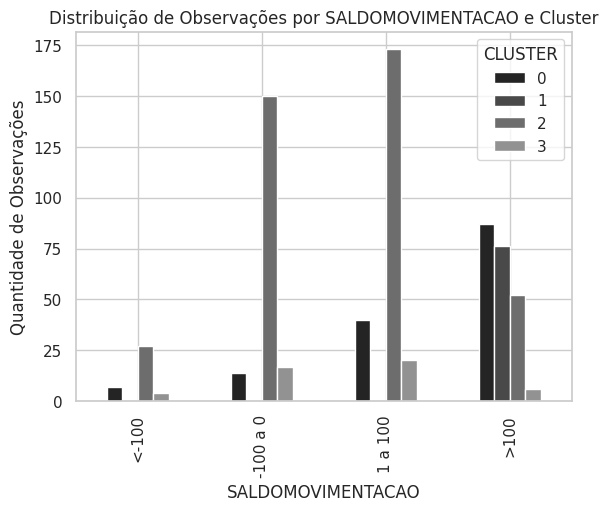

In [24]:
#Análise SALDOMOVIMENTACAO
# Definindo os limites das faixas
bins = [-float('inf'), -100, 0, 100, float('inf')]
# Definindo os rótulos das faixas
labels = ['<-100', '-100 a 0', '1 a 100', '>100']
# Aplicando a função pd.cut para categorizar as faixas
df_final['SALDOMOVIMENTACAO_FAIXA'] = pd.cut(df_final['SALDOMOVIMENTACAO'], bins=bins, labels=labels)
# Criar uma tabela de contagem cruzada (crosstab) para Faixa_Emprego e k_cluster
contagem = pd.crosstab(df_final['SALDOMOVIMENTACAO_FAIXA'], df_final['CLUSTER'])
# Criando o gráfico de barras empilhadas
contagem.plot(kind='bar', stacked=False)
# Adicionando títulos e rótulos
plt.xlabel('SALDOMOVIMENTACAO')
plt.ylabel('Quantidade de Observações')
plt.title('Distribuição de Observações por SALDOMOVIMENTACAO e Cluster')
# Exibir o gráfico
plt.show()

/tmp/ipykernel_1628323/246779108.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



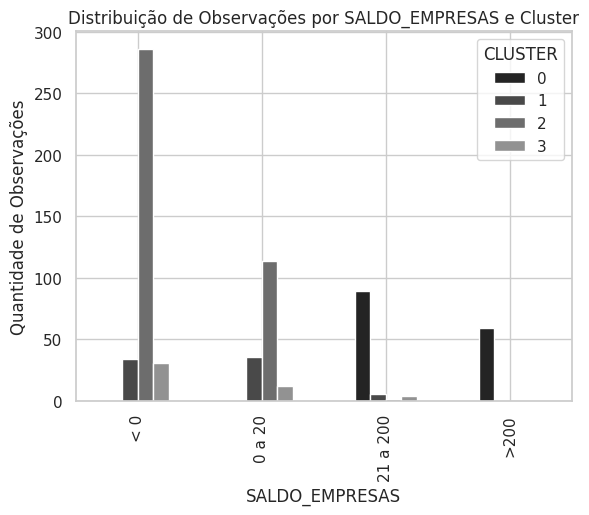

In [25]:
#Análise SALDO_EMPRESAS
# Definindo os limites das faixas
bins = [-float('inf'), 0, 20, 200, float('inf')]
# Definindo os rótulos das faixas
labels = ['< 0', '0 a 20', '21 a 200', '>200']
# Aplicando a função pd.cut para categorizar as faixas
df_final['SALDO_EMPRESAS_FAIXA'] = pd.cut(df_final['SALDO_EMPRESAS'], bins=bins, labels=labels)
# Criar uma tabela de contagem cruzada (crosstab) para Faixa_Emprego e k_cluster
contagem = pd.crosstab(df_final['SALDO_EMPRESAS_FAIXA'], df_final['CLUSTER'])
# Criando o gráfico de barras empilhadas
contagem.plot(kind='bar', stacked=False)
# Adicionando títulos e rótulos
plt.xlabel('SALDO_EMPRESAS')
plt.ylabel('Quantidade de Observações')
plt.title('Distribuição de Observações por SALDO_EMPRESAS e Cluster')
# Exibir o gráfico
plt.show()

/tmp/ipykernel_1628323/3605589798.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



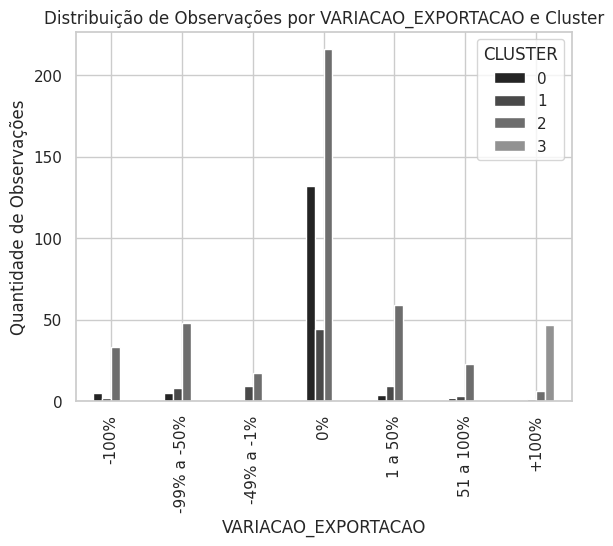

In [26]:
#Análise VARIACAO_EXPORTACAO
# Definindo os limites das faixas
bins = [-float('inf'),-0.5, -0.1, -0.01, 0, 0.5, 1, float('inf')]
# Definindo os rótulos das faixas
labels = ['-100%','-99% a -50%','-49% a -1%', '0%', '1 a 50%', '51 a 100%', '+100%']
# Aplicando a função pd.cut para categorizar as faixas
df_final['VARIACAO_EXPORTACAO_FAIXA'] = pd.cut(df_final['VARIACAO_EXPORTACAO'], bins=bins, labels=labels)
# Criar uma tabela de contagem cruzada (crosstab) para Faixa_Emprego e k_cluster
contagem = pd.crosstab(df_final['VARIACAO_EXPORTACAO_FAIXA'], df_final['CLUSTER'])
# Criando o gráfico de barras empilhadas
contagem.plot(kind='bar', stacked=False)
# Adicionando títulos e rótulos
plt.xlabel('VARIACAO_EXPORTACAO')
plt.ylabel('Quantidade de Observações')
plt.title('Distribuição de Observações por VARIACAO_EXPORTACAO e Cluster')
# Exibir o gráfico
plt.show()

In [41]:
df_final.groupby('CLUSTER').size()

CLUSTER
0    148
1     76
2    402
3     47
dtype: int64

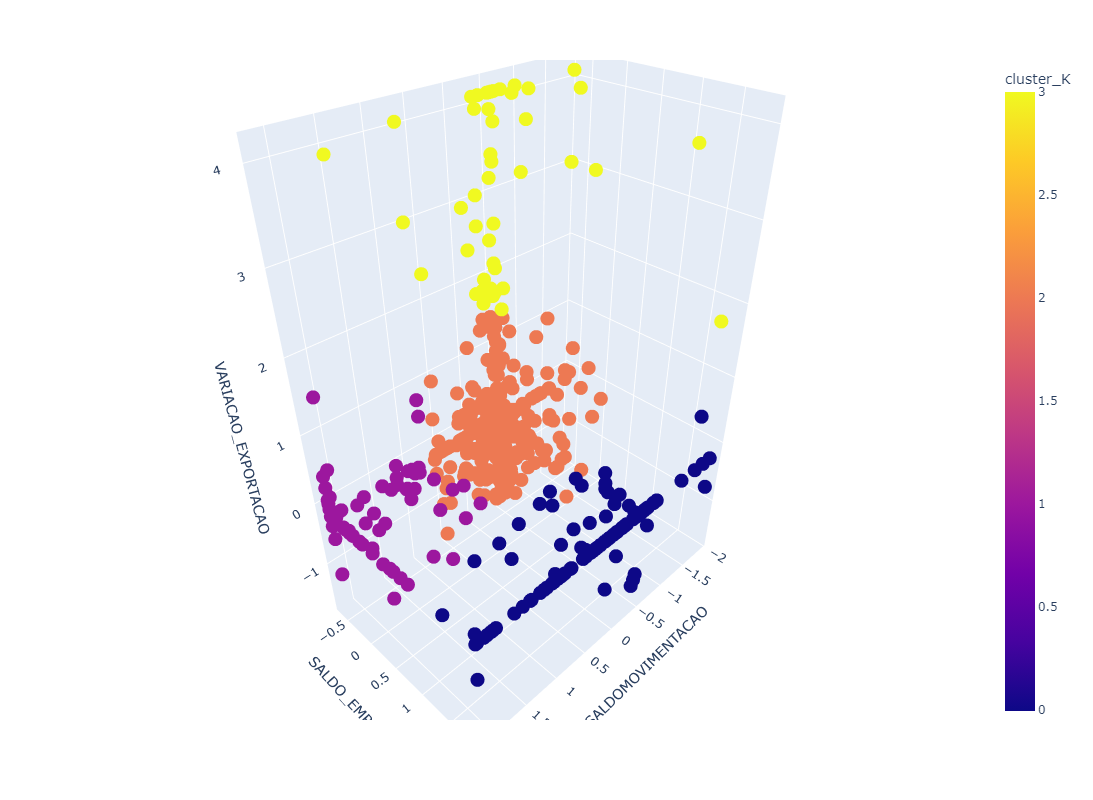

In [38]:
# Criação do gráfico 3D dos clusters formados
fig = px.scatter_3d(
    df_cluster,
    x='SALDOMOVIMENTACAO',
    y='SALDO_EMPRESAS',
    z='VARIACAO_EXPORTACAO',
    color='cluster_K'
)

# Aumentar o tamanho da exibição do gráfico
fig.update_layout(
    width=1200,  # Largura em pixels
    height=800   # Altura em pixels
)

fig.show()


In [46]:
# Agrupando as descrições de classe por cluster
lista_por_cluster = df_final.groupby('CLUSTER')['DESCRICAO_CLASSE'].apply(list).to_dict()

# Exibindo o resultado
print(lista_por_cluster)

{0: ['Cultivo de soja', 'Criação de bovinos', 'Atividades de apoio à agricultura', 'Atividades de apoio à pecuária', 'Fabricação de produtos de panificação', 'Fabricação de estruturas de madeira e de artigos de carpintaria para construção', 'Fabricação de produtos cerâmicos não refratários não especificados anteriormente', 'Aparelhamento e outros trabalhos em pedras', 'Fabricação de esquadrias de metal', 'Produção de artefatos estampados de metal; metalurgia do pó', 'Serviços de usinagem, solda, tratamento e revestimento em metais', 'Fabricação de artigos de serralheria, exceto esquadrias', 'Fabricação de produtos de metal não especificados anteriormente', 'Fabricação de máquinas e equipamentos para a agricultura e pecuária, exceto para irrigação', 'Recondicionamento e recuperação de motores para veículos automotores', 'Fabricação de móveis com predominância de madeira', 'Fabricação de móveis de outros materiais, exceto madeira e metal', 'Manutenção e reparação de máquinas e equipament